# EXPLORATION 06. 영화리뷰 텍스트 감성분석하기

## 1. 데이터 준비와 확인

### 필요한 모듈 import하기

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import numpy as np
import tensorflow as tf
import os

In [2]:
import pandas as pd

## 데이터를 읽어보자. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더 구성

### 수행내용  
- 데이터의 중복 제거   
- NaN 결측치 제거   
- 불용어(Stopwords) 제거   
- 사전 (word_to_index) 구성   
- 텍스트 스트링을 사전 인덱스 스트링으로 변환  
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) ## 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] ## 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) ## 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] ## 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
imdb = tf.keras.datasets.imdb

## IMDb 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

훈련 샘플 개수: 25000, 테스트 개수: 25000


In [5]:
## 딕셔너리 생성
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
## 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수이다. 
## 단, 모든 문장은 <BOS>로 시작하는 것으로 한다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

## 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수이다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

## 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수이다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:]) ##[1:]를 통해 <BOS>를 제외

## 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수이다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

for i in range(10):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print('라벨: ', y_train[i])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  1
[1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391]
. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나
라벨:  0
[24, 205, 2]
재 <UNK>
라벨:  0
[8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479]
이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정
라벨:  1
[2, 8894, 1108, 52, 2832, 60, 5, 14, 2758, 41, 1188, 35, 351, 42, 22, 40, 60, 2, 2, 427, 3102, 1766, 6]
익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다
라벨:  0
[675, 2, 2, 131, 420, 185, 1547, 712, 65, 1694, 715, 53, 375, 192, 271, 5, 4, 69, 4, 11, 2179, 122, 750, 4]
<UNK> <UNK> 3 세 부터 초등 학교 1 학년 생 인 8 살 용 영화 . ㅋㅋㅋ . .. 별반 개 아까움 .
라벨:  0
[253, 381, 9, 384, 2012, 55, 15, 817, 6, 4]
긴장감 을 제대로 살려 내 지 못했 다 .
라벨:  1
[232, 1450, 144, 6, 425, 756, 2, 2, 52, 1532, 290, 99, 250, 4, 4, 28, 855, 29, 353, 652, 540, 509, 583, 6, 3318, 4, 8895, 22, 1460, 1460, 4, 4, 71, 304, 17, 6, 52, 104, 8, 77, 22, 2, 43]
반개 아깝 다 욕 나온다 <UNK> <UNK> 연기 생활 몇 년 인지 . . 정말 발 로 해도 그

## 3. 모델 구성을 위한 데이터 분석 및 가공

In [7]:
total_data_text = list(x_train) + list(x_test)
## 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
## 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

## 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


## 4. 모델 구성 및 validation set 구성

### 첫 번째 모델 : RNN 모델 (model_A)

In [9]:
vocab_size = 10000  ## 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 16  ## 단어 하나를 표현하는 임베딩 벡터의 차원수

model_A = tf.keras.Sequential()
model_A.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_A.add(tf.keras.layers.LSTM(8))   ## 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용 => 이때 LSTM state 벡터의 차원수는 8로 함. (변경 가능)
model_A.add(tf.keras.layers.Dense(8, activation='relu'))
model_A.add(tf.keras.layers.Dense(1, activation='sigmoid'))  ## 최종 출력은 긍정/부정을 나타내는 1dim 이다.

model_A.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [10]:
## validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

## validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


### model 학습

In [11]:
model_A.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  ## epoch 값 을 적당한 걸로 학습시키면서 달리함. 

history = model_A.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 4s 45ms/step - loss: 0.6931 - accuracy: 0.5082 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 2/10
30/30 [==============================] - 1s 29ms/step - loss: 0.6929 - accuracy: 0.5071 - val_loss: 0.6931 - val_accuracy: 0.5006
Epoch 3/10
30/30 [==============================] - 1s 29ms/step - loss: 0.6925 - accuracy: 0.5155 - val_loss: 0.6930 - val_accuracy: 0.5022
Epoch 4/10
30/30 [==============================] - 1s 29ms/step - loss: 0.6914 - accuracy: 0.5141 - val_loss: 0.6920 - val_accuracy: 0.5058
Epoch 5/10
30/30 [==============================] - 1s 29ms/step - loss: 0.6873 - accuracy: 0.5161 - val_loss: 0.6888 - val_accuracy: 0.5064
Epoch 6/10
30/30 [==============================] - 1s 30ms/step - loss: 0.6793 - accuracy: 0.5246 - val_loss: 0.6718 - val_accuracy: 0.5558
Epoch 7/10
30/30 [==============================] - 1s 29ms/step - loss: 0.6583 - accuracy: 0.6833 - val_loss: 0.5922 - val_accuracy: 0.7187
Epoch 8/10
30

In [12]:
## 학습이 끝난 모델을 테스트셋으로 평가해보기! 
## model_A는 정확도가 50.29 로 생각보다 낮게 나왔다.

results = model_A.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 5s - loss: 0.7020 - accuracy: 0.5029
[0.7020447850227356, 0.5029199719429016]


In [13]:
history_dict = history.history
print(history_dict.keys()) ## epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


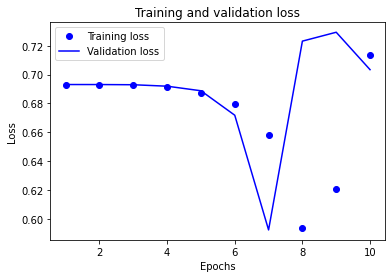

In [14]:
## Training and validation loss그래프

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

## "bo"는 "파란색 점"이다.
plt.plot(epochs, loss, 'bo', label='Training loss')
## b는 "파란 실선"이다.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

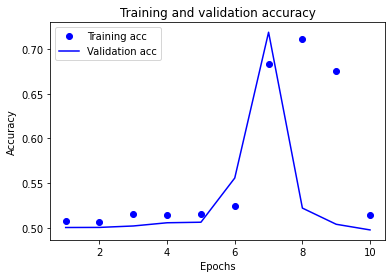

In [15]:
plt.clf()   ## 그림을 초기화!

## Training and validation accuracy 그래프

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 두 번째 모델 : 1-D CNN 모델 (model_B)

In [16]:
vocab_size = 10000  ## 어휘 사전의 크기이다.(10000개의 단어)
word_vector_dim = 16   ## 단어 하나를 표현하는 임베딩 벡터의 차원 수이다. 

model_B = tf.keras.Sequential()
model_B.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_B.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_B.add(tf.keras.layers.MaxPooling1D(5))
model_B.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_B.add(tf.keras.layers.GlobalMaxPooling1D())
model_B.add(tf.keras.layers.Dense(8, activation='relu'))
model_B.add(tf.keras.layers.Dense(1, activation='sigmoid'))  ## 최종 출력은 긍정/부정을 나타내는 1dim 이다.

model_B.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [17]:
## validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

## validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


### model 학습

In [18]:
model_B.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  ## 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾼다. 

history = model_B.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 3s 29ms/step - loss: 0.6931 - accuracy: 0.5123 - val_loss: 0.6927 - val_accuracy: 0.5149
Epoch 2/10
30/30 [==============================] - 1s 19ms/step - loss: 0.6904 - accuracy: 0.6894 - val_loss: 0.6892 - val_accuracy: 0.7177
Epoch 3/10
30/30 [==============================] - 1s 19ms/step - loss: 0.6747 - accuracy: 0.7851 - val_loss: 0.6479 - val_accuracy: 0.7049
Epoch 4/10
30/30 [==============================] - 1s 19ms/step - loss: 0.5575 - accuracy: 0.8092 - val_loss: 0.4447 - val_accuracy: 0.8423
Epoch 5/10
30/30 [==============================] - 1s 19ms/step - loss: 0.3280 - accuracy: 0.8785 - val_loss: 0.3237 - val_accuracy: 0.8678
Epoch 6/10
30/30 [==============================] - 1s 19ms/step - loss: 0.2176 - accuracy: 0.9189 - val_loss: 0.3134 - val_accuracy: 0.8688
Epoch 7/10
30/30 [==============================] - 1s 19ms/step - loss: 0.1599 - accuracy: 0.9459 - val_loss: 0.3215 - val_accuracy: 0.8684
Epoch 8/10
30

In [19]:
## 테스트 평가하기
## 정확도가 85.12로 제일 높에 나왔다.

results = model_B.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 1s - loss: 0.4224 - accuracy: 0.8512
[0.4224364757537842, 0.8512399792671204]


In [20]:
y_dict = history.history
print(history_dict.keys()) ## epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


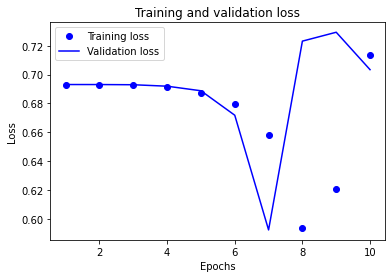

In [21]:
## Training and validation loss그래프

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

## "bo"는 "파란색 점"이다.
plt.plot(epochs, loss, 'bo', label='Training loss')
## b는 "파란 실선"이다.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

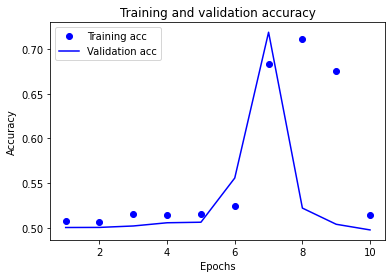

In [22]:
plt.clf()   ## 그림을 초기화한다.

## Training and validation accuracy 그래프

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 세 번째 모델 : GlobalMaxPooling1D() 모델 (model_C)

In [23]:
vocab_size = 10000  ## 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 16   ##단어 하나를 표현하는 임베딩 벡터의 차원 수이다. 

model_C = tf.keras.Sequential()
model_C.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_C.add(tf.keras.layers.GlobalMaxPooling1D())
model_C.add(tf.keras.layers.Dense(8, activation='relu'))
model_C.add(tf.keras.layers.Dense(1, activation='sigmoid'))  ## 최종 출력은 긍정/부정을 나타내는 1dim 이다.

model_C.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [24]:
## validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

## validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


### model 학습

In [25]:
model_C.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  ## 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾼다. 

history = model_C.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
30/30 [==============================] - 1s 11ms/step - loss: 0.6911 - accuracy: 0.5060 - val_loss: 0.6877 - val_accuracy: 0.5318
Epoch 2/15
30/30 [==============================] - 0s 7ms/step - loss: 0.6788 - accuracy: 0.6953 - val_loss: 0.6704 - val_accuracy: 0.7368
Epoch 3/15
30/30 [==============================] - 0s 7ms/step - loss: 0.6536 - accuracy: 0.7780 - val_loss: 0.6412 - val_accuracy: 0.7691
Epoch 4/15
30/30 [==============================] - 0s 7ms/step - loss: 0.6128 - accuracy: 0.8121 - val_loss: 0.5966 - val_accuracy: 0.7986
Epoch 5/15
30/30 [==============================] - 0s 6ms/step - loss: 0.5555 - accuracy: 0.8389 - val_loss: 0.5386 - val_accuracy: 0.8179
Epoch 6/15
30/30 [==============================] - 0s 6ms/step - loss: 0.4863 - accuracy: 0.8544 - val_loss: 0.4777 - val_accuracy: 0.8276
Epoch 7/15
30/30 [==============================] - 0s 6ms/step - loss: 0.4220 - accuracy: 0.8612 - val_loss: 0.4305 - val_accuracy: 0.8346
Epoch 8/15
30/30 [=

In [26]:
## 테스트 평가
## 정확도가 84.60 으로 적당하게 나왔다.

results = model_C.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 1s - loss: 0.3521 - accuracy: 0.8460
[0.3520919978618622, 0.8459600210189819]


In [27]:
history_dict = history.history
print(history_dict.keys()) ## epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


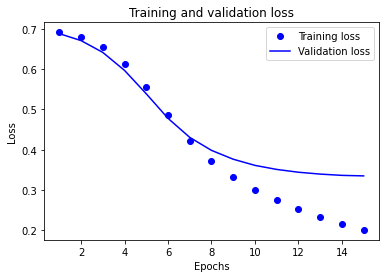

In [28]:
## Training and validation loss그래프

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

## "bo"는 "파란색 점"이다.
plt.plot(epochs, loss, 'bo', label='Training loss')
## b는 "파란 실선"이다.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

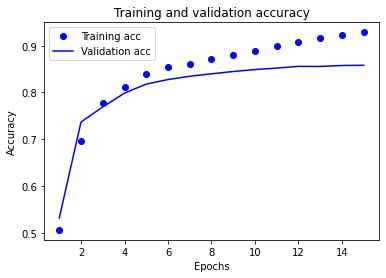

In [29]:
plt.clf()   ## 그림을 초기화한다.

## Training and validation accuracy 그래프

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 차원 변경!

In [30]:
import gensim

gensim.__version__

'3.8.3'

In [31]:
!pip install gensim

!pip install --upgrade gensim==3.8.3

In [32]:
import gensim

gensim.__version__

## 잘 변경 된 것을 볼 수 있다.
## 차원변경을 한 뒤에는 꼭 Restart 를 눌러줘야함~

'3.8.3'

## 학습된 Embedding 레이어 분석

In [33]:
## 애매하게 정확도가 나온 모델C 를 데리고 왔다.
embedding_layer = model_C.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    ## shape: (vocab_size, embedding_dim)

(10000, 16)


In [34]:
import os
from gensim import models     ## gensim : 워드벡터를 다루는데 유용한 패키지


## 학습한 Embedding 파라미터를 파일에 써서 저장한다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  ## 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 쓴다,.

## 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록한다. 
vectors = model_C.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [35]:
## embedding 한 파라미터를 읽어서 word_vector로 활용!

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['행복']
vector

array([-0.01439515, -0.04398841, -0.01055439, -0.02430906, -0.02442553,
       -0.04300826, -0.01445729, -0.01236375, -0.0173094 , -0.0149243 ,
        0.0148047 , -0.01373007, -0.02252706, -0.0144562 , -0.01866916,
       -0.01691782], dtype=float32)

In [36]:
word_vectors.similar_by_word("행복")

## 결과를 보면 "행복"이라는 단어와 유사하지 않음

[('마이', 0.9738633632659912),
 ('경찰', 0.9712220430374146),
 ('미침', 0.9627574682235718),
 ('시', 0.9544246196746826),
 ('로웠', 0.9529285430908203),
 ('에게', 0.9518726468086243),
 ('(', 0.9516945481300354),
 ('낚였', 0.9510214328765869),
 ('귀엽', 0.9497208595275879),
 ('비둘기', 0.9429367780685425)]

In [37]:
##from gensim.models import KeyedVectors

##word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
##word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=False)
##vector = word2vec["행복"]
##vector     # 무려 300dim의 워드 벡터입니다.



## 자꾸 에러가 뜸
## 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

### 임베딩 모델 (ko.bin)을 다운받아서 전이학습 시킴

In [38]:
## 위에 코드가 에러가 떠서 바꿈

from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec["행복"]
vector.shape

/tmp/ipykernel_3630/2666872737.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec["행복"]


(200,)

In [39]:
## 메모리를 다소 많이 소비하는 작업이니 유의
word2vec.similar_by_word("행복")


## 아까 위에 코드보다는 "행복"이라는 단어와 유사한 단어들이 있음을 알 수 있다.

/tmp/ipykernel_3630/250036510.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("행복")


[('사랑', 0.6759077310562134),
 ('기쁨', 0.6493781805038452),
 ('즐거움', 0.6396492719650269),
 ('삶', 0.6299898028373718),
 ('젊음', 0.6187379360198975),
 ('즐겁', 0.6027448177337646),
 ('인생', 0.6002243161201477),
 ('존엄', 0.5952589511871338),
 ('고독', 0.5938762426376343),
 ('불행', 0.5894461870193481)]

### embedding matrix

In [40]:
vocab_size = 10000    ## 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  ## 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

## embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_3630/1730871920.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_3630/1730871920.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [41]:
## 학습이 되어있는 Word2Vec 모델을 사용해서 불러오기


from tensorflow.keras.initializers import Constant


model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 580, 200)          2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 580, 200)          2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
______________________

### model 훈련

In [42]:
## 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=25  ## 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꿔본다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/25
235/235 [==============================] - 10s 39ms/step - loss: 0.6974 - accuracy: 0.5031 - val_loss: 0.6935 - val_accuracy: 0.5017
Epoch 2/25
235/235 [==============================] - 9s 38ms/step - loss: 0.6879 - accuracy: 0.5157 - val_loss: 0.6983 - val_accuracy: 0.5085
Epoch 3/25
235/235 [==============================] - 9s 38ms/step - loss: 0.6791 - accuracy: 0.5222 - val_loss: 0.6918 - val_accuracy: 0.5096
Epoch 4/25
235/235 [==============================] - 9s 38ms/step - loss: 0.6682 - accuracy: 0.5313 - val_loss: 0.7098 - val_accuracy: 0.5057
Epoch 5/25
235/235 [==============================] - 9s 38ms/step - loss: 0.6610 - accuracy: 0.5318 - val_loss: 0.7044 - val_accuracy: 0.5058
Epoch 6/25
235/235 [==============================] - 9s 38ms/step - loss: 0.6538 - accuracy: 0.5447 - val_loss: 0.6867 - val_accuracy: 0.5122
Epoch 7/25
235/235 [==============================] - 9s 38ms/step - loss: 0.6127 - accuracy: 0.6700 - val_loss: 0.5755 - val_accuracy: 0.737

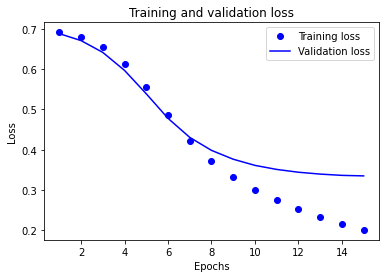

In [43]:
## Training and validation loss그래프

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

## "bo"는 "파란색 점"이다.
plt.plot(epochs, loss, 'bo', label='Training loss')
## b는 "파란 실선"이다.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

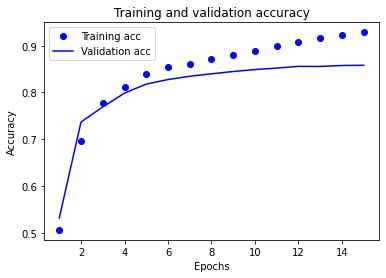

In [44]:
plt.clf()   ## 그림을 초기화

## Training and validation accuracy 그래프

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [45]:
## 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

## accuracy 가 85.33으로 잘 나옴

782/782 - 7s - loss: 0.6132 - accuracy: 0.8533
[0.6132077574729919, 0.8533200025558472]


# 회고!

## <어려웠던 점>  
그냥 코드가 너무 길고 할 게 생각보다 많아서 모델을 학습하고 준비하는데 시간이 많이 걸렸던 것 같다. 그리고 모델을 학습할 때마다 마지막 accuracy 가 달라져서 맞추는데 시간이 걸렸던 것 같다. 아마 지금까지 한 프로젝트 6개 중에 제일 오래걸렸고 제일 짜증났던 것 같다. 

## <알아낸 점> & <아직까지 모호한 점>  
모델에 따라서 정확도나 loss값이 달라지는 것을 보면서 되게 신기했던 것 같다. 그리고 코드가 기니까 여러 다양한 에러들이 떴는데 에러코드를 좀 더 빠르게 잡는 법을 알게 된 것 같다. 아직까지 모호한 점은 일단 중간에 ko.bin을 불러오는 과정에서 주석처리를 해뒀는데 에러가 자꾸 떴다. 에러를 잡고 그 원래 코드에서 수정을 해보려고 했지만 잘 되지 않아서 새로운 코드를 다시 찾아서 작성했다. 아직까지 그 에러를 못 잡아서 애매하게 끝난 것 같다. 

## <시도한 것들>  
사실 accuracy 가 85%를 넘어야 루브릭 기준을 만족하는데 84.56%, 84.97% 이렇게 나왔다. 반올림을 하면 될 것 같았지만 애매해서 다시 시도를 했다. 일단 각 모델의 epoch을 달리 해가면서 봤고 최종 epoch 은 하다하다 25까지 늘려서 학습을 했더니 값이 조금 올라갔다. 그리고 batch_size도 조금씩 달리해서 결과값에 영향을 주려고 했다. 하지만 그것도 잘 되지 않았던 것 같고, 모델을 원래는 B 모델을 했는데 값이 떨어져서 C모델로 바꿨더니 기존에 accuracy 가 84.얼마가 나왔는데 학습을 하고나서 개선이 되어 85%가 넘게 되었다.

## <자기 다짐>  
그냥 이번에는 너무 힘들었고 제일 별로였던 것 같다. 코드가 기니까 에러를 잡기도 힘들었고, 쉽지 않았다. 하지만 뭐 에러를 많이 보고 하니까 조금은 성장한 것 같다. 그리고 lms 익스를 할 때는 루브릭기준 부터 보고 해야겠다. 그냥 단순히 하니까 기준에 안맞아서 나중에 너무 고생을 하는 것 같다.